In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

from common import *

torch.manual_seed(42)

In [2]:
!pip install wandb

import wandb

wandb.login()

wandb: Currently logged in as: elliotcsmith. Use `wandb login --relogin` to force relogin


True

In [3]:
train_dataloader, val_dataloader = get_dataloaders() # From common.py

# What We're Building

(Modified from the original source: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

![](./u-net-architecture-edit.png)

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, f_in : int, f_out : int):
        super().__init__()
        
        self.convs = nn.Sequential(
            nn.Conv2d(
                in_channels=f_in,
                out_channels=f_out,
                kernel_size = (3, 3),
                padding = 'same',
                bias=False # Batch norm makes bias pointless
            ),
            nn.BatchNorm2d(num_features=f_out),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=f_out,
                out_channels=f_out,
                kernel_size = (3, 3),
                padding = 'same',
                bias=False # Batch norm makes bias pointless
            ),
            nn.BatchNorm2d(num_features=f_out),
            
        )
        self.relu = nn.ReLU()
        
        if f_in == f_out:
            self.identity = lambda x: x
        else:
            self.identity = nn.Conv2d(
                in_channels=f_in,
                out_channels=f_out,
                kernel_size = (1, 1),
                padding = 'same',
            )
    
    def forward(self, x):
        y = self.convs(x)
        x_ = self.identity(x)
        y = y + x_
        return self.relu(y)

    
class BottleneckBlock(nn.Module):
    def __init__(self, f_in : int, f_out : int, f_mid : int):
        super().__init__()
        
        self.convs = nn.Sequential(
            nn.Conv2d(
                in_channels=f_in,
                out_channels=f_mid,
                kernel_size = (1, 1),
                padding = 'same',
                bias=False # Batch norm makes bias pointless
            ),
            nn.BatchNorm2d(num_features=f_mid),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=f_mid,
                out_channels=f_mid,
                kernel_size = (3, 3),
                padding = 'same',
                bias=False # Batch norm makes bias pointless
            ),
            nn.BatchNorm2d(num_features=f_mid),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=f_mid,
                out_channels=f_out,
                kernel_size = (1, 1),
                padding = 'same',
                bias=False # Batch norm makes bias pointless
            ),
            nn.BatchNorm2d(num_features=f_out),
            
        )
        self.relu = nn.ReLU()
        
        if f_in == f_out:
            self.identity = lambda x: x
        else:
            self.identity = nn.Conv2d(
                in_channels=f_in,
                out_channels=f_out,
                kernel_size = (1, 1),
                padding = 'same',
            )
    
    def forward(self, x):
        y = self.convs(x)
        x_ = self.identity(x)
        y = y + x_
        return self.relu(y)

    
class UpConv(nn.Module):
    def __init__(self, f_in : int, f_out : int):
        super().__init__()
        
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels = f_in,
                out_channels = f_out,
                kernel_size = (2, 2),
                padding = 'same'
            ),
            # Not sure if these make sense but testing
            nn.BatchNorm2d(num_features=f_out),
            nn.ReLU(),
        )
    
    def forward(self, x):
        y = self.up(x)
        y = self.conv(y)
        
        return y

    
class UNet(nn.Module):
    def __init__(self, channels : int, classes : int):
        super().__init__()
        
        # (A)
        self.c1 = ConvBlock(channels, 64)
        self.mp1 = nn.MaxPool2d(2)
        
        # (B)
        self.c2 = ConvBlock(64, 128)
        self.mp2 = nn.MaxPool2d(2)
        
        # (C)
        self.c3 = ConvBlock(128, 256)
        self.mp3 = nn.MaxPool2d(2) # 🎵
        
        # (D)
        self.c4 = ConvBlock(256, 512) # 💣
        self.mp4 = nn.MaxPool2d(2) # 📼
        
        # (E)
        self.c5 = ConvBlock(512, 1024)
        self.up1 = UpConv(1024, 512)
        
        # (F)
        self.c6 = ConvBlock(1024, 512)
        self.up2 = UpConv(512, 256)
        
        # (G)
        self.c7 = ConvBlock(512, 256)
        self.up3 = UpConv(256, 128)
        
        # (H)
        self.c8 = ConvBlock(256, 128)
        self.up4 = UpConv(128, 64)
        
        # (I)
        self.c9 = ConvBlock(128, 64)
        self.c_final = nn.Conv2d(
            in_channels = 64,
            out_channels = classes,
            kernel_size = (1, 1),
            stride = 1,
            padding = 'same'
        )
    
    def forward(self, x):
        # (A)
        y = self.c1(x)
        skip1 = y
        y = self.mp1(y) # 64 x 64
        
        # (B)
        y = self.c2(y)
        skip2 = y
        y = self.mp2(y) # 32 x 32
        
        # (C)
        y = self.c3(y)
        skip3 = y
        y = self.mp3(y) # 16 x 16
        
        # (D)
        y = self.c4(y)
        skip4 = y
        y = self.mp4(y) # 8 x 8
        
        # (E)
        y = self.c5(y)
        y = self.up1(y) # 16 x 16
        
        y = torch.cat((skip4, y), dim=1) # [batch, channels, x, y]
        
        # (F)
        y = self.c6(y)
        y = self.up2(y)
        
        y = torch.cat((skip3, y), dim=1)
        
        # (G)
        y = self.c7(y)
        y = self.up3(y)
        
        y = torch.cat((skip2, y), dim=1)
        
        # (H)
        y = self.c8(y)
        y = self.up4(y)
        
        y = torch.cat((skip1, y), dim=1)
        
        # (I)
        y = self.c9(y)
        y = self.c_final(y)
        
        # Done
        return y

In [5]:
# Define a training loop

hp = {
    'lr': 1e-2,
    'batch_size': 64,
    'epochs': 50,
    'variant': 'all-A'
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = UNet(
    channels=3,
    classes=2
).to(device)

loss_fn =  nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=hp['lr'])

Using cuda device


In [6]:
wandb.init(project="unet-streams", group="resnet", config = hp)

============= Epoch 0 ===============


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv2d(input, weight, bias, self.stride,


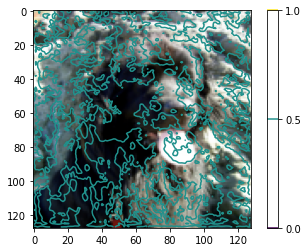

Mean batch loss on validation set: 0.746881 dice: 0.373258
loss: 0.756004 [    0/ 2944]
loss: 0.614745 [  320/ 2944]
loss: 0.576115 [  640/ 2944]
loss: 0.527590 [  960/ 2944]
loss: 0.491869 [ 1280/ 2944]
loss: 0.484085 [ 1600/ 2944]
loss: 0.466442 [ 1920/ 2944]
loss: 0.432057 [ 2240/ 2944]
loss: 0.424661 [ 2560/ 2944]
loss: 0.396003 [ 2880/ 2944]
============= Epoch 1 ===============


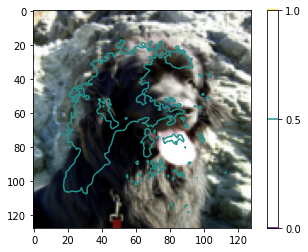

Mean batch loss on validation set: 0.414714 dice: 0.528181
loss: 0.418659 [    0/ 2944]
loss: 0.389795 [  320/ 2944]
loss: 0.392997 [  640/ 2944]
loss: 0.369475 [  960/ 2944]
loss: 0.364430 [ 1280/ 2944]
loss: 0.385918 [ 1600/ 2944]
loss: 0.407681 [ 1920/ 2944]
loss: 0.382318 [ 2240/ 2944]
loss: 0.336266 [ 2560/ 2944]
loss: 0.359450 [ 2880/ 2944]
============= Epoch 2 ===============


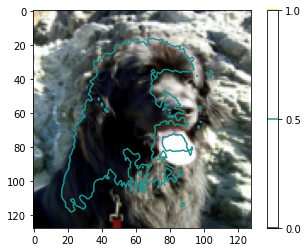

Mean batch loss on validation set: 0.368120 dice: 0.589060
loss: 0.361801 [    0/ 2944]
loss: 0.355311 [  320/ 2944]
loss: 0.353556 [  640/ 2944]
loss: 0.331034 [  960/ 2944]
loss: 0.321447 [ 1280/ 2944]
loss: 0.345317 [ 1600/ 2944]
loss: 0.393316 [ 1920/ 2944]
loss: 0.340098 [ 2240/ 2944]
loss: 0.319119 [ 2560/ 2944]
loss: 0.332311 [ 2880/ 2944]
============= Epoch 3 ===============


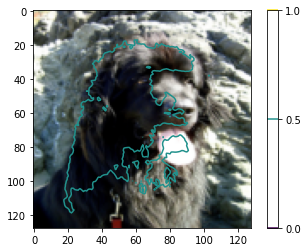

Mean batch loss on validation set: 0.347469 dice: 0.617129
loss: 0.320557 [    0/ 2944]
loss: 0.323305 [  320/ 2944]
loss: 0.330615 [  640/ 2944]
loss: 0.304020 [  960/ 2944]
loss: 0.307483 [ 1280/ 2944]
loss: 0.339448 [ 1600/ 2944]
loss: 0.365988 [ 1920/ 2944]
loss: 0.324309 [ 2240/ 2944]
loss: 0.305599 [ 2560/ 2944]
loss: 0.318963 [ 2880/ 2944]
============= Epoch 4 ===============


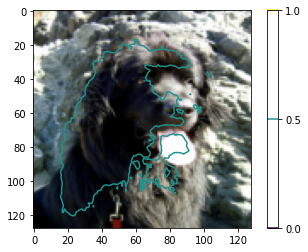

Mean batch loss on validation set: 0.336501 dice: 0.634300
loss: 0.325411 [    0/ 2944]
loss: 0.318134 [  320/ 2944]
loss: 0.316178 [  640/ 2944]
loss: 0.285206 [  960/ 2944]
loss: 0.285406 [ 1280/ 2944]
loss: 0.318839 [ 1600/ 2944]
loss: 0.352989 [ 1920/ 2944]
loss: 0.316334 [ 2240/ 2944]
loss: 0.287915 [ 2560/ 2944]
loss: 0.303959 [ 2880/ 2944]
============= Epoch 5 ===============


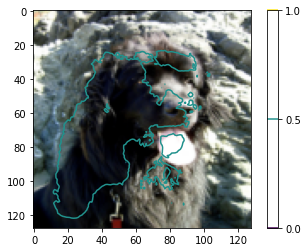

Mean batch loss on validation set: 0.322629 dice: 0.650880
loss: 0.313735 [    0/ 2944]
loss: 0.283700 [  320/ 2944]
loss: 0.307150 [  640/ 2944]
loss: 0.280412 [  960/ 2944]
loss: 0.273062 [ 1280/ 2944]
loss: 0.314161 [ 1600/ 2944]
loss: 0.325964 [ 1920/ 2944]
loss: 0.308885 [ 2240/ 2944]
loss: 0.275520 [ 2560/ 2944]
loss: 0.298334 [ 2880/ 2944]
============= Epoch 6 ===============


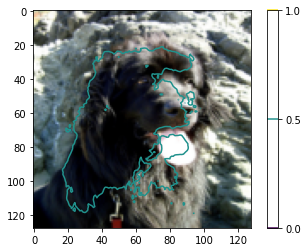

Mean batch loss on validation set: 0.314864 dice: 0.664895
loss: 0.297356 [    0/ 2944]
loss: 0.280927 [  320/ 2944]
loss: 0.302375 [  640/ 2944]
loss: 0.262039 [  960/ 2944]
loss: 0.263849 [ 1280/ 2944]
loss: 0.304502 [ 1600/ 2944]
loss: 0.311935 [ 1920/ 2944]
loss: 0.288560 [ 2240/ 2944]
loss: 0.281383 [ 2560/ 2944]
loss: 0.281350 [ 2880/ 2944]
============= Epoch 7 ===============


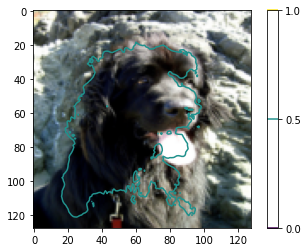

Mean batch loss on validation set: 0.305783 dice: 0.674206
loss: 0.273148 [    0/ 2944]
loss: 0.256709 [  320/ 2944]
loss: 0.282626 [  640/ 2944]
loss: 0.264459 [  960/ 2944]
loss: 0.258936 [ 1280/ 2944]
loss: 0.286169 [ 1600/ 2944]
loss: 0.300500 [ 1920/ 2944]
loss: 0.278902 [ 2240/ 2944]
loss: 0.262345 [ 2560/ 2944]
loss: 0.266728 [ 2880/ 2944]
============= Epoch 8 ===============


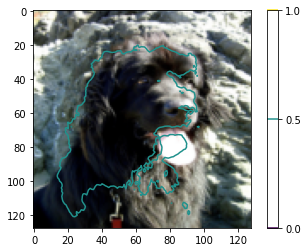

Mean batch loss on validation set: 0.299257 dice: 0.684180
loss: 0.279103 [    0/ 2944]
loss: 0.257012 [  320/ 2944]
loss: 0.294485 [  640/ 2944]
loss: 0.238992 [  960/ 2944]
loss: 0.256144 [ 1280/ 2944]
loss: 0.282821 [ 1600/ 2944]
loss: 0.284945 [ 1920/ 2944]
loss: 0.278562 [ 2240/ 2944]
loss: 0.252904 [ 2560/ 2944]
loss: 0.263313 [ 2880/ 2944]
============= Epoch 9 ===============


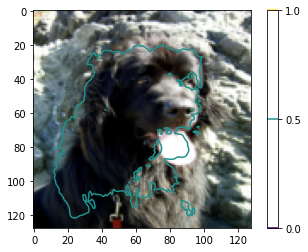

Mean batch loss on validation set: 0.292558 dice: 0.693874
loss: 0.267393 [    0/ 2944]
loss: 0.260304 [  320/ 2944]
loss: 0.249531 [  640/ 2944]
loss: 0.229581 [  960/ 2944]
loss: 0.242145 [ 1280/ 2944]
loss: 0.276754 [ 1600/ 2944]
loss: 0.334543 [ 1920/ 2944]
loss: 0.269377 [ 2240/ 2944]
loss: 0.244347 [ 2560/ 2944]
loss: 0.266373 [ 2880/ 2944]
============= Epoch 10 ===============


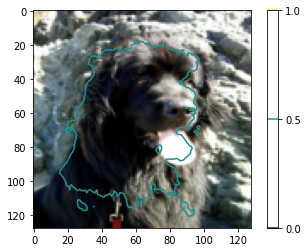

Mean batch loss on validation set: 0.291759 dice: 0.696495
loss: 0.277103 [    0/ 2944]
loss: 0.255050 [  320/ 2944]
loss: 0.267486 [  640/ 2944]
loss: 0.233461 [  960/ 2944]
loss: 0.244050 [ 1280/ 2944]
loss: 0.273906 [ 1600/ 2944]
loss: 0.264383 [ 1920/ 2944]
loss: 0.253856 [ 2240/ 2944]
loss: 0.248943 [ 2560/ 2944]
loss: 0.252621 [ 2880/ 2944]
============= Epoch 11 ===============


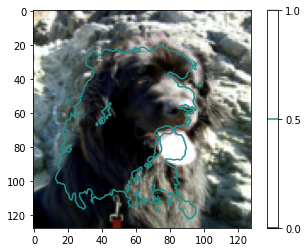

Mean batch loss on validation set: 0.282801 dice: 0.705529
loss: 0.263690 [    0/ 2944]
loss: 0.236129 [  320/ 2944]
loss: 0.253473 [  640/ 2944]
loss: 0.233398 [  960/ 2944]
loss: 0.229057 [ 1280/ 2944]
loss: 0.246679 [ 1600/ 2944]
loss: 0.285601 [ 1920/ 2944]
loss: 0.245609 [ 2240/ 2944]
loss: 0.227809 [ 2560/ 2944]
loss: 0.242191 [ 2880/ 2944]
============= Epoch 12 ===============


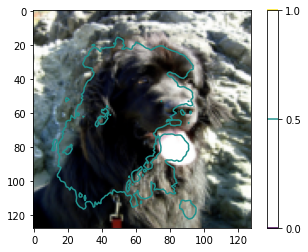

Mean batch loss on validation set: 0.278080 dice: 0.712031
loss: 0.243868 [    0/ 2944]
loss: 0.234430 [  320/ 2944]
loss: 0.243777 [  640/ 2944]
loss: 0.231933 [  960/ 2944]
loss: 0.229216 [ 1280/ 2944]
loss: 0.230913 [ 1600/ 2944]
loss: 0.253894 [ 1920/ 2944]
loss: 0.241370 [ 2240/ 2944]
loss: 0.207807 [ 2560/ 2944]
loss: 0.249947 [ 2880/ 2944]
============= Epoch 13 ===============


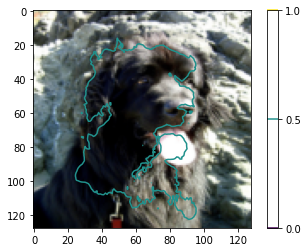

Mean batch loss on validation set: 0.279659 dice: 0.716080
loss: 0.227265 [    0/ 2944]
loss: 0.223654 [  320/ 2944]
loss: 0.237495 [  640/ 2944]
loss: 0.212582 [  960/ 2944]
loss: 0.222579 [ 1280/ 2944]
loss: 0.244951 [ 1600/ 2944]
loss: 0.223726 [ 1920/ 2944]
loss: 0.231002 [ 2240/ 2944]
loss: 0.242933 [ 2560/ 2944]
loss: 0.245887 [ 2880/ 2944]
============= Epoch 14 ===============


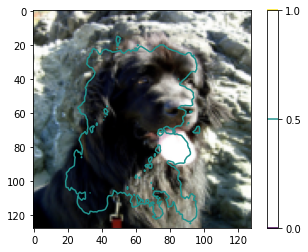

Mean batch loss on validation set: 0.274949 dice: 0.720883
loss: 0.236653 [    0/ 2944]
loss: 0.227686 [  320/ 2944]
loss: 0.218584 [  640/ 2944]
loss: 0.205931 [  960/ 2944]
loss: 0.212926 [ 1280/ 2944]
loss: 0.223927 [ 1600/ 2944]
loss: 0.281772 [ 1920/ 2944]
loss: 0.243224 [ 2240/ 2944]
loss: 0.216255 [ 2560/ 2944]
loss: 0.230651 [ 2880/ 2944]
============= Epoch 15 ===============


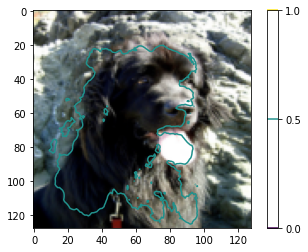

Mean batch loss on validation set: 0.275205 dice: 0.721235
loss: 0.240150 [    0/ 2944]
loss: 0.214916 [  320/ 2944]
loss: 0.231178 [  640/ 2944]
loss: 0.214390 [  960/ 2944]
loss: 0.206640 [ 1280/ 2944]
loss: 0.235672 [ 1600/ 2944]
loss: 0.256820 [ 1920/ 2944]
loss: 0.235276 [ 2240/ 2944]
loss: 0.199033 [ 2560/ 2944]
loss: 0.216427 [ 2880/ 2944]
============= Epoch 16 ===============


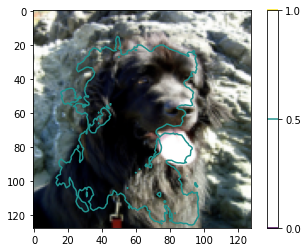

Mean batch loss on validation set: 0.269298 dice: 0.731981
loss: 0.207794 [    0/ 2944]
loss: 0.219790 [  320/ 2944]
loss: 0.215350 [  640/ 2944]
loss: 0.195046 [  960/ 2944]
loss: 0.204262 [ 1280/ 2944]
loss: 0.236793 [ 1600/ 2944]
loss: 0.221081 [ 1920/ 2944]
loss: 0.234908 [ 2240/ 2944]
loss: 0.217263 [ 2560/ 2944]
loss: 0.212838 [ 2880/ 2944]
============= Epoch 17 ===============


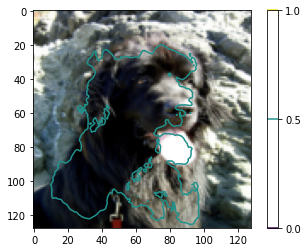

Mean batch loss on validation set: 0.268901 dice: 0.733874
loss: 0.214994 [    0/ 2944]
loss: 0.198953 [  320/ 2944]
loss: 0.201797 [  640/ 2944]
loss: 0.194225 [  960/ 2944]
loss: 0.211409 [ 1280/ 2944]
loss: 0.236720 [ 1600/ 2944]
loss: 0.236903 [ 1920/ 2944]
loss: 0.200602 [ 2240/ 2944]
loss: 0.219894 [ 2560/ 2944]
loss: 0.200315 [ 2880/ 2944]
============= Epoch 18 ===============


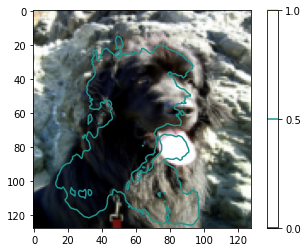

Mean batch loss on validation set: 0.268109 dice: 0.736027
loss: 0.206794 [    0/ 2944]
loss: 0.218675 [  320/ 2944]
loss: 0.193644 [  640/ 2944]
loss: 0.180899 [  960/ 2944]
loss: 0.190550 [ 1280/ 2944]
loss: 0.209376 [ 1600/ 2944]
loss: 0.253587 [ 1920/ 2944]
loss: 0.200063 [ 2240/ 2944]
loss: 0.187522 [ 2560/ 2944]
loss: 0.191152 [ 2880/ 2944]
============= Epoch 19 ===============


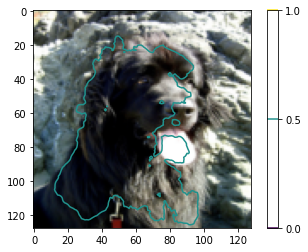

Mean batch loss on validation set: 0.261847 dice: 0.743013
loss: 0.214052 [    0/ 2944]
loss: 0.195379 [  320/ 2944]
loss: 0.235866 [  640/ 2944]
loss: 0.198591 [  960/ 2944]
loss: 0.172654 [ 1280/ 2944]
loss: 0.212577 [ 1600/ 2944]
loss: 0.217786 [ 1920/ 2944]
loss: 0.197421 [ 2240/ 2944]
loss: 0.208162 [ 2560/ 2944]
loss: 0.188774 [ 2880/ 2944]
============= Epoch 20 ===============


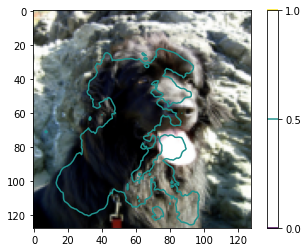

Mean batch loss on validation set: 0.262894 dice: 0.743446
loss: 0.194988 [    0/ 2944]
loss: 0.178429 [  320/ 2944]
loss: 0.179558 [  640/ 2944]
loss: 0.185969 [  960/ 2944]
loss: 0.192338 [ 1280/ 2944]
loss: 0.200681 [ 1600/ 2944]
loss: 0.215694 [ 1920/ 2944]
loss: 0.219141 [ 2240/ 2944]
loss: 0.206501 [ 2560/ 2944]
loss: 0.185863 [ 2880/ 2944]
============= Epoch 21 ===============


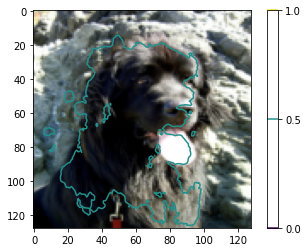

loss: 0.182144 [  640/ 2944]
loss: 0.151881 [  960/ 2944]
loss: 0.150440 [ 1280/ 2944]
loss: 0.140525 [ 1600/ 2944]
loss: 0.159552 [ 1920/ 2944]
loss: 0.161043 [ 2240/ 2944]
loss: 0.137260 [ 2560/ 2944]
loss: 0.163189 [ 2880/ 2944]
============= Epoch 34 ===============


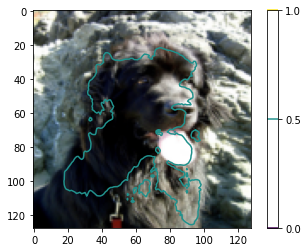

Mean batch loss on validation set: 0.261204 dice: 0.772784
loss: 0.151225 [    0/ 2944]
loss: 0.143765 [  320/ 2944]
loss: 0.163779 [  640/ 2944]
loss: 0.156508 [  960/ 2944]
loss: 0.137493 [ 1280/ 2944]
loss: 0.164867 [ 1600/ 2944]
loss: 0.158415 [ 1920/ 2944]
loss: 0.173000 [ 2240/ 2944]
loss: 0.174367 [ 2560/ 2944]
loss: 0.153389 [ 2880/ 2944]
============= Epoch 35 ===============


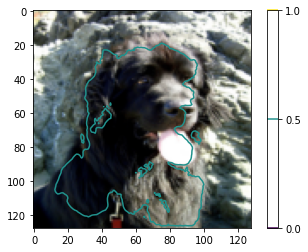

Mean batch loss on validation set: 0.257889 dice: 0.777861
loss: 0.191567 [    0/ 2944]
loss: 0.158270 [  320/ 2944]
loss: 0.146204 [  640/ 2944]
loss: 0.125705 [  960/ 2944]
loss: 0.136046 [ 1280/ 2944]
loss: 0.175778 [ 1600/ 2944]
loss: 0.199294 [ 1920/ 2944]
loss: 0.136646 [ 2240/ 2944]
loss: 0.129860 [ 2560/ 2944]
loss: 0.153746 [ 2880/ 2944]
============= Epoch 36 ===============


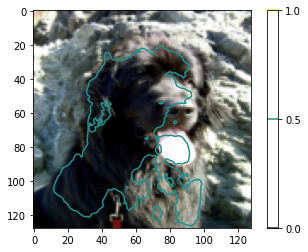

Mean batch loss on validation set: 0.266565 dice: 0.772218
loss: 0.148208 [    0/ 2944]
loss: 0.131100 [  320/ 2944]
loss: 0.145230 [  640/ 2944]
loss: 0.138989 [  960/ 2944]
loss: 0.131521 [ 1280/ 2944]
loss: 0.148461 [ 1600/ 2944]
loss: 0.151271 [ 1920/ 2944]
loss: 0.130874 [ 2240/ 2944]
loss: 0.133990 [ 2560/ 2944]
loss: 0.140410 [ 2880/ 2944]
============= Epoch 37 ===============


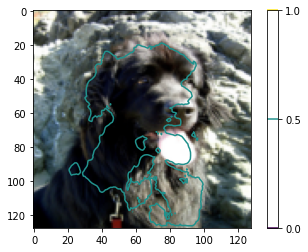

Mean batch loss on validation set: 0.259783 dice: 0.779841
loss: 0.131075 [    0/ 2944]
loss: 0.150788 [  320/ 2944]
loss: 0.170859 [  640/ 2944]
loss: 0.137948 [  960/ 2944]
loss: 0.129843 [ 1280/ 2944]
loss: 0.137392 [ 1600/ 2944]
loss: 0.187457 [ 1920/ 2944]
loss: 0.130983 [ 2240/ 2944]
loss: 0.119670 [ 2560/ 2944]
loss: 0.127470 [ 2880/ 2944]
============= Epoch 38 ===============


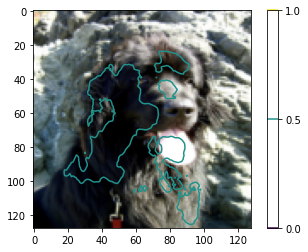

Mean batch loss on validation set: 0.259088 dice: 0.781290
loss: 0.122624 [    0/ 2944]
loss: 0.130028 [  320/ 2944]
loss: 0.148269 [  640/ 2944]
loss: 0.124260 [  960/ 2944]
loss: 0.125982 [ 1280/ 2944]
loss: 0.145406 [ 1600/ 2944]
loss: 0.160335 [ 1920/ 2944]
loss: 0.137764 [ 2240/ 2944]
loss: 0.161762 [ 2560/ 2944]
loss: 0.150862 [ 2880/ 2944]
============= Epoch 39 ===============


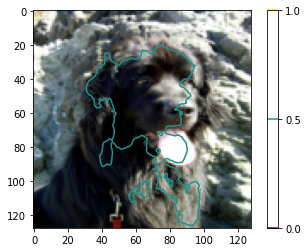

Mean batch loss on validation set: 0.261013 dice: 0.783931
loss: 0.122185 [    0/ 2944]
loss: 0.159169 [  320/ 2944]
loss: 0.155559 [  640/ 2944]
loss: 0.147252 [  960/ 2944]
loss: 0.153417 [ 1280/ 2944]
loss: 0.139944 [ 1600/ 2944]
loss: 0.140424 [ 1920/ 2944]
loss: 0.141008 [ 2240/ 2944]
loss: 0.137081 [ 2560/ 2944]
loss: 0.158529 [ 2880/ 2944]
============= Epoch 40 ===============


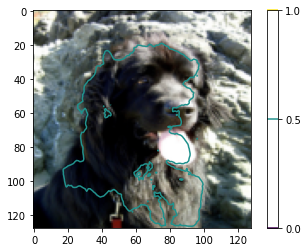

Mean batch loss on validation set: 0.279039 dice: 0.773838
loss: 0.127446 [    0/ 2944]
loss: 0.140589 [  320/ 2944]
loss: 0.155219 [  640/ 2944]
loss: 0.138520 [  960/ 2944]
loss: 0.138454 [ 1280/ 2944]
loss: 0.135257 [ 1600/ 2944]
loss: 0.138479 [ 1920/ 2944]
loss: 0.125368 [ 2240/ 2944]
loss: 0.140117 [ 2560/ 2944]
loss: 0.144420 [ 2880/ 2944]
============= Epoch 41 ===============


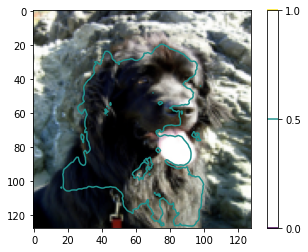

Mean batch loss on validation set: 0.260061 dice: 0.785719
loss: 0.130342 [    0/ 2944]
loss: 0.148514 [  320/ 2944]
loss: 0.138695 [  640/ 2944]
loss: 0.129426 [  960/ 2944]
loss: 0.130375 [ 1280/ 2944]
loss: 0.153702 [ 1600/ 2944]
loss: 0.154433 [ 1920/ 2944]
loss: 0.138247 [ 2240/ 2944]
loss: 0.129480 [ 2560/ 2944]
loss: 0.156928 [ 2880/ 2944]
============= Epoch 42 ===============


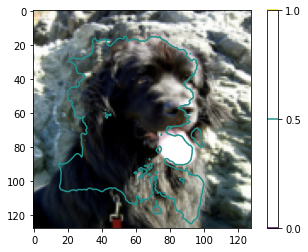

Mean batch loss on validation set: 0.282286 dice: 0.775920
loss: 0.152969 [    0/ 2944]
loss: 0.131598 [  320/ 2944]
loss: 0.173303 [  640/ 2944]
loss: 0.140785 [  960/ 2944]
loss: 0.121827 [ 1280/ 2944]
loss: 0.148279 [ 1600/ 2944]
loss: 0.128971 [ 1920/ 2944]
loss: 0.150873 [ 2240/ 2944]
loss: 0.133485 [ 2560/ 2944]
loss: 0.151371 [ 2880/ 2944]
============= Epoch 43 ===============


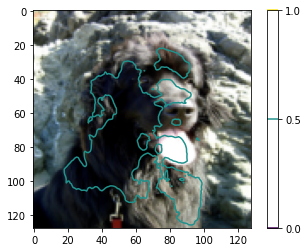

Mean batch loss on validation set: 0.258913 dice: 0.787088
loss: 0.113062 [    0/ 2944]
loss: 0.127416 [  320/ 2944]
loss: 0.135050 [  640/ 2944]
loss: 0.130163 [  960/ 2944]
loss: 0.131819 [ 1280/ 2944]
loss: 0.131066 [ 1600/ 2944]
loss: 0.137676 [ 1920/ 2944]
loss: 0.150862 [ 2240/ 2944]
loss: 0.132833 [ 2560/ 2944]
loss: 0.145922 [ 2880/ 2944]
============= Epoch 44 ===============


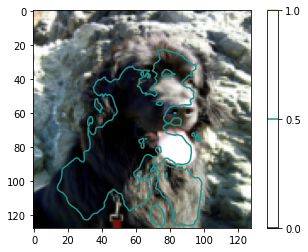

Mean batch loss on validation set: 0.264661 dice: 0.783761
loss: 0.142366 [    0/ 2944]
loss: 0.135351 [  320/ 2944]
loss: 0.144936 [  640/ 2944]
loss: 0.125860 [  960/ 2944]
loss: 0.119814 [ 1280/ 2944]
loss: 0.139888 [ 1600/ 2944]
loss: 0.211872 [ 1920/ 2944]
loss: 0.122122 [ 2240/ 2944]
loss: 0.121218 [ 2560/ 2944]
loss: 0.137089 [ 2880/ 2944]
============= Epoch 45 ===============


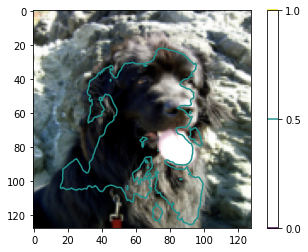

Mean batch loss on validation set: 0.261488 dice: 0.789807
loss: 0.126465 [    0/ 2944]
loss: 0.117842 [  320/ 2944]
loss: 0.138803 [  640/ 2944]
loss: 0.118601 [  960/ 2944]
loss: 0.116989 [ 1280/ 2944]
loss: 0.121934 [ 1600/ 2944]
loss: 0.143728 [ 1920/ 2944]
loss: 0.130612 [ 2240/ 2944]
loss: 0.115937 [ 2560/ 2944]
loss: 0.124925 [ 2880/ 2944]
============= Epoch 46 ===============


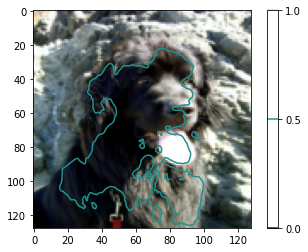

Mean batch loss on validation set: 0.262764 dice: 0.792353
loss: 0.150596 [    0/ 2944]
loss: 0.117594 [  320/ 2944]
loss: 0.126233 [  640/ 2944]
loss: 0.113997 [  960/ 2944]
loss: 0.131294 [ 1280/ 2944]
loss: 0.115785 [ 1600/ 2944]
loss: 0.161415 [ 1920/ 2944]
loss: 0.137037 [ 2240/ 2944]
loss: 0.131500 [ 2560/ 2944]
loss: 0.123182 [ 2880/ 2944]
============= Epoch 47 ===============


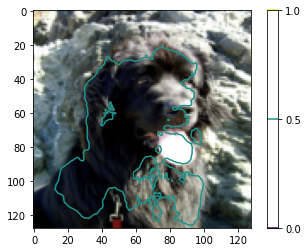

Mean batch loss on validation set: 0.266278 dice: 0.791359
loss: 0.139412 [    0/ 2944]
loss: 0.114873 [  320/ 2944]
loss: 0.154305 [  640/ 2944]
loss: 0.136914 [  960/ 2944]
loss: 0.134992 [ 1280/ 2944]
loss: 0.199958 [ 1600/ 2944]
loss: 0.195940 [ 1920/ 2944]
loss: 0.133768 [ 2240/ 2944]
loss: 0.124757 [ 2560/ 2944]
loss: 0.151999 [ 2880/ 2944]
============= Epoch 48 ===============


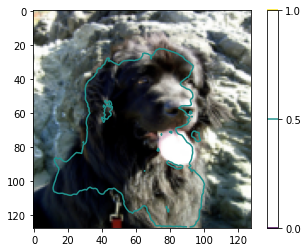

Mean batch loss on validation set: 0.263343 dice: 0.786122
loss: 0.128035 [    0/ 2944]
loss: 0.114855 [  320/ 2944]


In [ ]:
step = 0

for i in range(hp['epochs']):
    print(f"============= Epoch {i} ===============")
    test_loop(val_dataloader, model, loss_fn, device, step=step, wb=wandb)
    step = train_loop(train_dataloader, model, loss_fn, optimizer, device, step=step, wb=wandb)